In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

import numpy as np
np.set_printoptions(suppress=True)

from pyspark import SparkContext
from lib.table import Table

# start spark with 1 worker thread
sc = SparkContext("local[*]")
sc.setLogLevel("ERROR")

21/12/07 18:25:45 WARN Utils: Your hostname, pasokon resolves to a loopback address: 127.0.1.1; using 192.168.1.96 instead (on interface wlo1)
21/12/07 18:25:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/07 18:25:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### What is the distribution of the machines according to their CPU capacity?

In [2]:
machine_events = Table('machine_events', sc)
machine_events.pprint(take=5)

,time,machine_id,event_type,platform_id,cpus,memory
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [3]:
cpu_dist = machine_events.select(['cpus']).countByValue()
for cpu_type, value in cpu_dist.items():
    print(f'cpu type: {cpu_type[0]}, count: {value}')

cpu type: 0.5, count: 35015
cpu type: 0.25, count: 510
cpu type: 1, count: 2223
cpu type: NA, count: 32


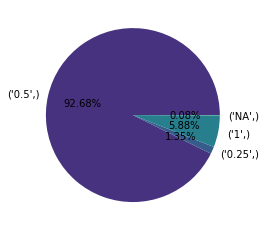

In [5]:
plt.pie(cpu_dist.values(), labels=cpu_dist.keys(), colors = colors, autopct='%.2f%%')
plt.show()

### On average, how many tasks compose a job?

In [6]:
task_events = Table('task_events', sc)
task_events.pprint(3)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,0,2,3418309,0,4155527081,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
1,0,2,3418309,1,329150663,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,NA,NA,NA,NA
2,0,NA,3418314,0,3938719206,0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3,9,0.125,0.07446,0.0004244,0


In [8]:

job = task_events.select(['job_id'])
task_per_job = list(job.countByValue().values())
np.max(task_per_job), np.min(task_per_job), np.mean(task_per_job), np.std(task_per_job) 

(46037, 1, 91.96036772216547, 843.9305821206359)

## What is the distribution of the number jobs/tasks per scheduling class?

In [8]:
## Version 1: bad
def to_list(a):
    return [[a[0]], [a[1]]]

def append(a, b):
    a[0].append(b[0])
    a[1].append(b[1])
    return [a[0], a[1]]

def extend(a, b):
    a[0].extend(b[0])
    a[1].extend(b[1])
    return [a[0], a[1]]

In [9]:
def init(new):
    job = set()
    job.add(new)
    return [job, 1]

def merge(old, new):
    old[0].add(new)
    return [old[0], old[1] + 1]

def combine(c1, c2):
    c1[0].union(c2[0])
    return [c1[0], c1[1]+c2[1]]

In [10]:
job_task_sched = task_events.select(['scheduling_class','job_id'])
res = job_task_sched.combineByKey(init, merge, combine).mapValues(lambda x: (len(x[0]), x[1]))
print('\n'.join(f'scheduling class [{s}], #job: {j}, #task: {t}' for \
            s, (j,t) in res.collect()))

scheduling class [1], #job: 1253, #task: 58109
scheduling class [0], #job: 580, #task: 237969
scheduling class [3], #job: 922, #task: 56586
scheduling class [2], #job: 1226, #task: 97482


### Do tasks with low priority have a higher probability of being evicted?

In [11]:
rdd = task_events.select(['event_type', 'priority'])\
        .filter(lambda x: x[0] == '2')\
        .map(lambda x: int(x[1]))

total_evicted = rdd.count()
p = rdd.countByValue()
for k,v in sorted(p.items()):
    print(f'priority [{k}] = {round(v/total_evicted, 4)}')

priority [0] = 0.97
priority [1] = 0.012
priority [2] = 0.0127
priority [9] = 0.0051
priority [10] = 0.0002


### In general, do tasks from the same job run on the same machine?

In [12]:
task_events.select(['job_id', 'machine_id'])\
           .groupByKey()\
           .mapValues(lambda x: len(set(x)))\
           .sortBy(lambda x: x[1], ascending=False)\
           .take(5)

[('6221861800', 10093),
 ('6225099547', 4104),
 ('5402488769', 4051),
 ('2902878580', 3881),
 ('6238340468', 3067)]

## Are the tasks that request the more resources the one that consume the more resources?

In [18]:
task_usage = Table('task_usage', spark_context=sc)
task_usage.pprint(5)

,start_time,end_time,job_id,task_index,machine_id,cpu_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_i/o_time,local_disk_space_usage,maximum_cpu_rate,maximum_disk_io_time,cycles_per_instruction,memory_accesses_per_instruction,sample_portion,aggregation_type,sampled_cpu_usage
0,5612000000,5700000000,4665712499,369,4820204869,0.03143,0.05389,0.06946,0.005997,0.006645,0.05408,7.629e-05,0.0003834,0.2415,0.002571,2.911,NA,0,0,0.02457
1,5612000000,5700000000,4665712499,798,3349189123,0.02698,0.06714,0.07715,0.004219,0.004868,0.06726,7.915e-05,0.0003681,0.27,0.00293,3.285,0.008261,0,0,0.01608
2,5612000000,5700000000,4665896876,251,372630265,0.04114,0.06714,0.07739,0.002956,0.003605,0.0675,0.0001135,0.000371,0.1086,0.004784,1.551,0.002311,0,0,0.05286
3,5612000000,5613000000,5285926325,0,2850406,0,0,0,0,0,0,0,0,0,0,NA,NA,0,0,0
4,5612000000,5700000000,6000618870,74,1437119225,0.07275,0.01898,0.02716,0.0008469,0.002251,0.01901,0,0,0.2415,0,1.3,0.0005437,0,0,0.06238


### CPU usage

In [ ]:
cpu_req = task_events.select(['job_id','task_index','cpu_request'])\
                     .filter(lambda x: x[2] != 'NA')\
                     .map(lambda x: ((x[0],x[1]),float(x[2])))
cpu_req.take(5)

[(('3418314', '0'), 0.125),
 (('3418314', '1'), 0.125),
 (('3418368', '0'), 0.03125),
 (('3418368', '1'), 0.03125),
 (('3418368', '2'), 0.03125)]

In [ ]:
cpu_us = task_usage.select(['job_id','task_index','cpu_rate'])\
                   .filter(lambda x: x[2] != 'NA')\
                   .map(lambda x: ((x[0],x[1]),float(x[2])))
cpu_us.take(5)

[(('3418309', '0'), 0.001562),
 (('3418309', '1'), 0.001568),
 (('3418314', '0'), 0.0003071),
 (('3418314', '1'), 0.0003004),
 (('3418319', '0'), 0.0004606)]

In [ ]:
cpu_cons = cpu_req.join(cpu_us)
cpu_cons.take(5)

[(('17109330', '5'), (0.0625, 0.03589)),
 (('17109330', '5'), (0.0625, 0.03528)),
 (('17109330', '5'), (0.0625, 0.03662)),
 (('17109330', '5'), (0.0625, 0.03351)),
 (('17109330', '5'), (0.0625, 0.03339))]

In [ ]:
def avg_init(row):
    return (row[0], row[1], 1)

def avg_merge(old, new):
    return (old[0]+new[0],old[1]+new[1],old[2]+1)

def avg_cmb(old, new):
    return (old[0]+new[0],old[1]+new[1],old[2]+new[2])

cpu_cons_avg = cpu_cons.combineByKey(avg_init,avg_merge, avg_cmb)
cpu_cons_avg.take(10)

[(('17109330', '5'), (2.125, 1.21388, 34)),
 (('17109330', '11'), (2.125, 1.0815, 34)),
 (('17109330', '15'), (2.125, 1.2545199999999999, 34)),
 (('17109330', '31'), (2.125, 1.2263199999999999, 34)),
 (('17109330', '36'), (2.125, 1.53612, 34)),
 (('17109330', '49'), (2.125, 1.0648, 34)),
 (('17109330', '75'), (2.125, 1.1832200000000002, 34)),
 (('17109330', '92'), (2.125, 1.21472, 34)),
 (('17109330', '101'), (2.125, 1.1731200000000002, 34)),
 (('17109330', '109'), (2.125, 1.0849, 34))]

In [ ]:
cpu_cons_avg.mapValues(lambda x: (x[0]/x[2],x[1]/x[2])).sortBy(lambda x: x[1][0], ascending=False).take(10)

[(('6209468726', '0'), (0.5, 4.403705882352941e-05)),
 (('6211896520', '21'), (0.4375, 0.00046404117647058825)),
 (('6250599310', '0'), (0.4375, 3.545294117647058e-05)),
 (('4872450645', '0'), (0.40619999999999895, 0.00034414347826086953)),
 (('6000618870', '2'), (0.3812999999999997, 0.07919235294117648)),
 (('6000618870', '3'), (0.3812999999999997, 0.08186941176470588)),
 (('6000618870', '76'), (0.3812999999999997, 0.09581142857142855)),
 (('6000618870', '81'), (0.3812999999999997, 0.08018352941176468)),
 (('6000618870', '94'), (0.3812999999999997, 0.09100882352941178)),
 (('6000618870', '95'), (0.3812999999999997, 0.08955210526315788))]

### memroy request

In [ ]:
mem_req = task_events.select(['job_id','task_index','memory_request'])\
                     .filter(lambda x: x[2] != 'NA')\
                     .map(lambda x: ((x[0],x[1]),float(x[2])))
mem_us = task_usage.select(['job_id','task_index','canonical_memory_usage'])\
                   .filter(lambda x: x[2] != 'NA')\
                   .map(lambda x: ((x[0],x[1]),float(x[2])))
mem_cons = mem_req.join(mem_us)
mem_cons_avg = mem_cons.combineByKey(avg_init,avg_merge, avg_cmb)\
                       .mapValues(lambda x: (x[0]/x[2],x[1]/x[2]))\
                       .sortBy(lambda x: x[1][0], ascending=False)
mem_cons_avg.take(10)

[(('6024393894', '0'), (0.9551000000000007, 0.7519999999999998)),
 (('6024393894', '1'), (0.9551000000000007, 0.7519999999999998)),
 (('6184967406', '2'), (0.6367000000000002, 0.5254)),
 (('6184967406', '1'), (0.6367000000000002, 0.5812588235294115)),
 (('4472621957', '0'), (0.6367000000000002, 0.5527000000000001)),
 (('6184967406', '0'), (0.6367000000000002, 0.5944882352941174)),
 (('6184967359', '0'), (0.6367000000000002, 0.5605882352941174)),
 (('6088049389', '0'), (0.5098, 0.0012228823529411767)),
 (('5840251953', '0'), (0.5088000000000004, 0.4160294117647058)),
 (('259235987', '0'), (0.5088000000000004, 0.2930235294117647))]

### Disk I/O

In [ ]:
# TODO

## Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

In [19]:
task_usage.pprint(5)

,start_time,end_time,job_id,task_index,machine_id,cpu_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_i/o_time,local_disk_space_usage,maximum_cpu_rate,maximum_disk_io_time,cycles_per_instruction,memory_accesses_per_instruction,sample_portion,aggregation_type,sampled_cpu_usage
0,5612000000,5700000000,4665712499,369,4820204869,0.03143,0.05389,0.06946,0.005997,0.006645,0.05408,7.629e-05,0.0003834,0.2415,0.002571,2.911,NA,0,0,0.02457
1,5612000000,5700000000,4665712499,798,3349189123,0.02698,0.06714,0.07715,0.004219,0.004868,0.06726,7.915e-05,0.0003681,0.27,0.00293,3.285,0.008261,0,0,0.01608
2,5612000000,5700000000,4665896876,251,372630265,0.04114,0.06714,0.07739,0.002956,0.003605,0.0675,0.0001135,0.000371,0.1086,0.004784,1.551,0.002311,0,0,0.05286
3,5612000000,5613000000,5285926325,0,2850406,0,0,0,0,0,0,0,0,0,0,NA,NA,0,0,0
4,5612000000,5700000000,6000618870,74,1437119225,0.07275,0.01898,0.02716,0.0008469,0.002251,0.01901,0,0,0.2415,0,1.3,0.0005437,0,0,0.06238


In [41]:
max_cpu_task = task_usage.select(['job_id', 'maximum_cpu_rate'])\
                         .mapValues(lambda x: float(x))\
                         .reduceByKey(max)

In [83]:
from pyspark.sql import SparkSession
spark = SparkSession(sc)

te = task_events.select(['job_id', 'event_type'])
max_cpu_evt = te.join(max_cpu_task).map(lambda x: (int(x[1][0]), x[1][1])).collect()

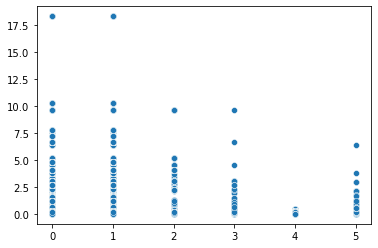

In [84]:
sns.scatterplot(x=[x[0] for x in max_cpu_evt], y=[x[1] for x in max_cpu_evt]);

## Does the number of constraints of a task (including different-machine constraint) have an impact on the amount of time it spends in the PENDING state